In [1]:
%load_ext autoreload
%autoreload 2

from utils import *
from fdaf import *
import IPython.display as ipd

In [2]:
h = None
signal_microphone, signal_loudspeaker, impulse_response, rate, near_end = generate_signals(h)

In [3]:
N = 500

# finish_index = 4 * rate # stop after 4 seconds
# signal_error, estimated_impulse_response = NLMS(signal_loudspeaker, signal_microphone, N, 0.5, 0.000001, freeze_index=finish_index)
signal_error, estimated_impulse_response = NLMS(signal_loudspeaker, signal_microphone, N, 0.5, 0.000001)

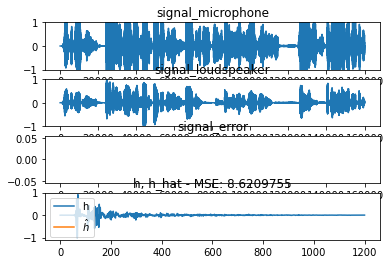

In [5]:
# print(h.shape)
plot_signals(signal_microphone, signal_loudspeaker, impulse_response, signal_error, estimated_impulse_response, N)

In [6]:
# Loudspeaker signal
ipd.Audio(signal_loudspeaker.reshape(-1), rate=rate)

In [7]:
# Microphone signal
ipd.Audio(signal_microphone.reshape(-1), rate=rate)

In [8]:
# Filtered signal
#ipd.Audio(signal_error.reshape(-1), rate=rate)

## Test BFDF

In [19]:
x = get_shifted_blocks(signal_loudspeaker,1024,512)
h = get_shifted_blocks(impulse_response,1024,512)
X = fft.fft(x)
H = fft.fft(h)
y = BFDF(X,H,512)
print(X.shape,H.shape,y.shape)
ipd.Audio(y.T,rate=rate)

(312, 1024) (2, 1024) (159744, 1)


## Test FDAF_OS

Block:  1
Block:  2
Block:  3
Block:  4
Block:  19
Block:  20
Block:  21
Block:  22
Block:  23
Block:  24
Block:  25
Block:  26
Block:  27
Block:  28
Block:  29
Block:  30
Block:  31
Block:  35
Block:  41
Block:  42
Block:  43
Block:  44
Block:  45
Block:  56
Block:  57
Block:  58
Block:  59
Block:  72
Block:  73
Block:  74
Block:  106
Block:  107
Block:  123
Block:  124
Block:  127


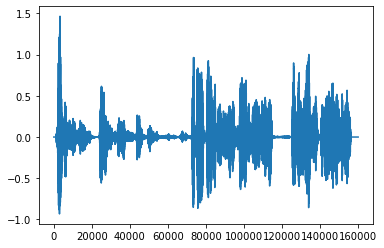

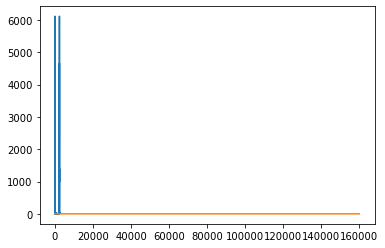

In [24]:
fi = np.asarray([[4,20]])*2*rate
fi = None
e,y,H,p = FDAF_OS(signal_loudspeaker,signal_microphone, freeze_index=fi)

plt.plot(e.ravel())
plt.figure()
plt.plot(p.T)
plt.plot(y)
ipd.Audio(y.ravel(),rate=rate)

In [25]:
ipd.Audio(e.ravel(),rate=rate)

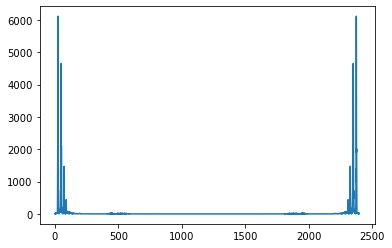

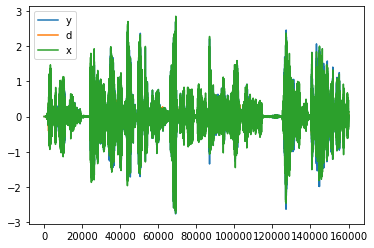

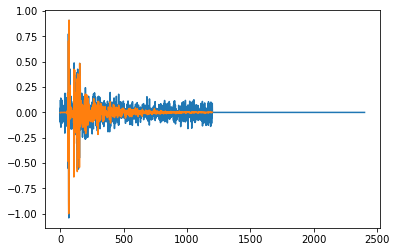

In [26]:
plt.plot(abs(p).ravel())
plt.figure()
plt.plot(y.ravel())
plt.plot(signal_loudspeaker.ravel())
plt.plot(signal_microphone.ravel())
plt.legend(['y','d','x'],loc='upper left')


plt.figure()
h = fft.ifft(H).real.ravel()
plt.plot(h)
plt.plot(impulse_response)
plt.show()